## Convolutional Neural Network



In this notebook you will learn to distinguish dogs from cats!

Data:
https://drive.google.com/drive/folders/1bkcr55sW6BrcgKVPEGTb3vvhpnrklKKq?usp=sharing

Fill in cells below and fit neural networks for solving the binary classification task.

**Requirement**
- Python, Pytorch (Must), and all other necessary libraries
- **Just don't cheat, Thanks!**
- Sample output is to help you understand the task, and get an idea of what you have to do
- Dur date is Nov 10, 11:59pm. You ONLY need to submit this notebook. Include instructions to run your code.

## Task 1(25 points):

1. Build and fit CNN with 3 convolutional layers for binary classification
2. Evaluate accuracy on test data
3. Plot the graphs for Loss(number_of_epochs) and Accuracy(number_of_epochs)

First, let's load all the necessary functions:


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Research on how to load google drive files into colab if you are using colab

In [ ]:
!cp '/content/drive/MyDrive/Cats_and_Dogs/test' ./
!cp '/content/drive/MyDrive/Cats_and_Dogs/train' ./
!cp '/content/drive/MyDrive/Cats_and_Dogs/val' ./

cp: -r not specified; omitting directory '/content/drive/MyDrive/Cats_and_Dogs/test'
cp: -r not specified; omitting directory '/content/drive/MyDrive/Cats_and_Dogs/train'
cp: -r not specified; omitting directory '/content/drive/MyDrive/Cats_and_Dogs/val'


In [ ]:
!unzip /content/test-20230725T062948Z-001.zip

In [ ]:
!unzip /content/train-20230725T062949Z-001.zip


In [ ]:
!unzip /content/val-20230725T062951Z-001.zip

In [ ]:
!ls train/dogs/ | wc -l

ls: cannot access 'train/dogs/': No such file or directory
0


The images collected for training and testing the deep learning model must be prepared: split the entire set into a training, validation and test sample, observing the balancing of classes (with binary classification they should be approximately equal in all three samples).

This has _already_ been done: in the Cats_and_Dogs directory there are three subdirectories: train, test and val - training, test and validation samples, respectively.

In [2]:
# Initialize the folders with train, test and validation datasets (in "/My Drive/..." or from your local repository where you have downloaded data):

train = '/content/drive/MyDrive/Cats_and_Dogs/train'
val = '/content/drive/MyDrive/Cats_and_Dogs/val'
test = '/content/drive/MyDrive/Cats_and_Dogs/test'

# The shape of the RGB image
img_width, img_height, channels = 150, 150, 3 # you can try different sizes

# input shape
input_shape = (img_width, img_height, 3)
# position matters!
# Number_of_channels can be at the first or the last position
# in our case - "channels last"

# minibatch size
batch_size = 32
# train set size
nb_train_samples = 20000
# validation set size
nb_validation_samples = 2490
# test set size
nb_test_samples = 2500

## Prepare the data.

In [3]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

resize = transforms.Resize(size=(img_height, img_width))
trainTransforms = transforms.Compose([resize, transforms.ToTensor()])
testTransforms = transforms.Compose([resize, transforms.ToTensor()])

train_path = '/content/drive/MyDrive/Cats_and_Dogs/train/'
test_path = '/content/drive/MyDrive/Cats_and_Dogs/test/'
val_path = '/content/drive/MyDrive/Cats_and_Dogs/val/'

train_data = ImageFolder(train_path, transform=trainTransforms)
test_data = ImageFolder(test_path, transform=testTransforms)
val_data = ImageFolder(val_path, transform=testTransforms)

# Setup the batch size hyperparameter
BATCH_SIZE = batch_size

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,num_workers=4, pin_memory= True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,num_workers=4, pin_memory= True)
val_dataloader = DataLoader(val_data,
                            batch_size=BATCH_SIZE,
                            shuffle=True,num_workers=4, pin_memory= True)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of val dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7df429c507c0>, <torch.utils.data.dataloader.DataLoader object at 0x7df40ffa0550>)
Length of train dataloader: 625 batches of 32
Length of test dataloader: 79 batches of 32
Length of val dataloader: 79 batches of 32


Set the network architecture by sequentially adding layers to it:
1. A convolutional layer with 16 neurons, filter size 3x3. Activation function - 'relu'
2. MaxPooling layer with filter size 2x2.
3. A convolutional layer with 32 neurons, filter size 3x3. Activation function - 'relu'
4. MaxPooling layer with filter size 2x2.
5. A convolutional layer with 64 neurons, filter size 3x3. Activation function - 'relu'
6. MaxPooling layer with filter size 2x2.
7. flatten, which makes a one-dimensional vector of the resulting feature maps.
8. A fully connected layer with 64 neurons. Activation function - 'relu'
9. Use Dropout (0.5) which excludes the edge from the current layer in the computational graph with a 50% probability to avoid overfitting.
10. A fully connected layer with 1 neuron. Activation function - 'sigmoid', because binary classification model.


In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch


class CatsVsDogsModel(nn.Module):
    def __init__(self):
        super(CatsVsDogsModel, self).__init__()

        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc_model = nn.Sequential(
            nn.Linear(64 * 17 * 17, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x

In [29]:
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

model = CatsVsDogsModel()
model = model.cuda()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.009, momentum=0.9)

num_epochs = 15
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_dataloader
        else:
            model.eval()
            dataloader = val_dataloader
        running_loss = 0.0
        running_corrects = 0
        count = 0
        for i, data in enumerate(tqdm(dataloader), 0):
            inputs, labels = data
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                preds = outputs > 0.5
                loss = criterion(outputs, labels.float().view_as(outputs))
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item()
            running_corrects += torch.sum(preds.view_as(labels) == labels.data)
            count += len(labels)
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = running_corrects.float() / count
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc)

Epoch 1/15
----------


100%|██████████| 625/625 [00:49<00:00, 12.51it/s]


train Loss: 0.6894 Acc: 0.5328


100%|██████████| 79/79 [00:06<00:00, 11.83it/s]


val Loss: 0.6761 Acc: 0.5884
Epoch 2/15
----------


100%|██████████| 625/625 [00:50<00:00, 12.45it/s]


train Loss: 0.6584 Acc: 0.6105


100%|██████████| 79/79 [00:06<00:00, 12.42it/s]


val Loss: 0.6340 Acc: 0.6559
Epoch 3/15
----------


100%|██████████| 625/625 [00:50<00:00, 12.34it/s]


train Loss: 0.6020 Acc: 0.6775


100%|██████████| 79/79 [00:06<00:00, 12.29it/s]


val Loss: 0.5643 Acc: 0.7132
Epoch 4/15
----------


100%|██████████| 625/625 [00:49<00:00, 12.61it/s]


train Loss: 0.5520 Acc: 0.7210


100%|██████████| 79/79 [00:06<00:00, 12.45it/s]


val Loss: 0.5514 Acc: 0.7255
Epoch 5/15
----------


100%|██████████| 625/625 [00:50<00:00, 12.36it/s]


train Loss: 0.4982 Acc: 0.7601


100%|██████████| 79/79 [00:06<00:00, 12.22it/s]


val Loss: 0.4963 Acc: 0.7636
Epoch 6/15
----------


100%|██████████| 625/625 [00:50<00:00, 12.38it/s]


train Loss: 0.4559 Acc: 0.7847


100%|██████████| 79/79 [00:06<00:00, 12.48it/s]


val Loss: 0.4629 Acc: 0.7867
Epoch 7/15
----------


100%|██████████| 625/625 [00:50<00:00, 12.47it/s]


train Loss: 0.4198 Acc: 0.8116


100%|██████████| 79/79 [00:06<00:00, 12.30it/s]


val Loss: 0.4680 Acc: 0.7863
Epoch 8/15
----------


100%|██████████| 625/625 [00:50<00:00, 12.47it/s]


train Loss: 0.3795 Acc: 0.8298


100%|██████████| 79/79 [00:06<00:00, 12.33it/s]


val Loss: 0.4478 Acc: 0.7906
Epoch 9/15
----------


100%|██████████| 625/625 [00:49<00:00, 12.55it/s]


train Loss: 0.3400 Acc: 0.8492


100%|██████████| 79/79 [00:06<00:00, 12.31it/s]


val Loss: 0.4244 Acc: 0.8085
Epoch 10/15
----------


100%|██████████| 625/625 [00:49<00:00, 12.61it/s]


train Loss: 0.2986 Acc: 0.8750


100%|██████████| 79/79 [00:06<00:00, 12.40it/s]


val Loss: 0.4703 Acc: 0.7898
Epoch 11/15
----------


 25%|██▌       | 159/625 [00:13<00:39, 11.95it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d3c7d4615a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d3c7d4615a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdo

train Loss: 0.2688 Acc: 0.8860


100%|██████████| 79/79 [00:06<00:00, 12.49it/s]


val Loss: 0.4571 Acc: 0.7902
Epoch 12/15
----------


100%|██████████| 625/625 [00:50<00:00, 12.46it/s]


train Loss: 0.2202 Acc: 0.9102


100%|██████████| 79/79 [00:06<00:00, 12.16it/s]


val Loss: 0.4772 Acc: 0.8014
Epoch 13/15
----------


100%|██████████| 625/625 [00:50<00:00, 12.50it/s]


train Loss: 0.1932 Acc: 0.9216


100%|██████████| 79/79 [00:06<00:00, 12.68it/s]


val Loss: 0.6116 Acc: 0.7898
Epoch 14/15
----------


100%|██████████| 625/625 [00:50<00:00, 12.39it/s]


train Loss: 0.1859 Acc: 0.9257


100%|██████████| 79/79 [00:06<00:00, 12.20it/s]


val Loss: 0.5199 Acc: 0.8065
Epoch 15/15
----------


100%|██████████| 625/625 [00:49<00:00, 12.54it/s]


train Loss: 0.1520 Acc: 0.9398


100%|██████████| 79/79 [00:06<00:00, 12.50it/s]

val Loss: 0.5707 Acc: 0.8033


In [30]:
# Test Code
model.eval()

test_loss = 0.0
test_corrects = 0
count = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader):
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        preds = outputs > 0.5
        loss = criterion(outputs, labels.float().view_as(outputs))
        test_loss += loss.item()
        test_corrects += torch.sum(preds.view_as(labels) == labels.data)
        count += len(labels)

test_loss = test_loss / len(test_dataloader)
test_accuracy = test_corrects.float() / count

print(f'Test Loss: {test_loss:.4f} Test Accuracy: {test_accuracy:.4f}')



100%|██████████| 79/79 [00:06<00:00, 12.51it/s]

Test Loss: 0.5326 Test Accuracy: 0.8084


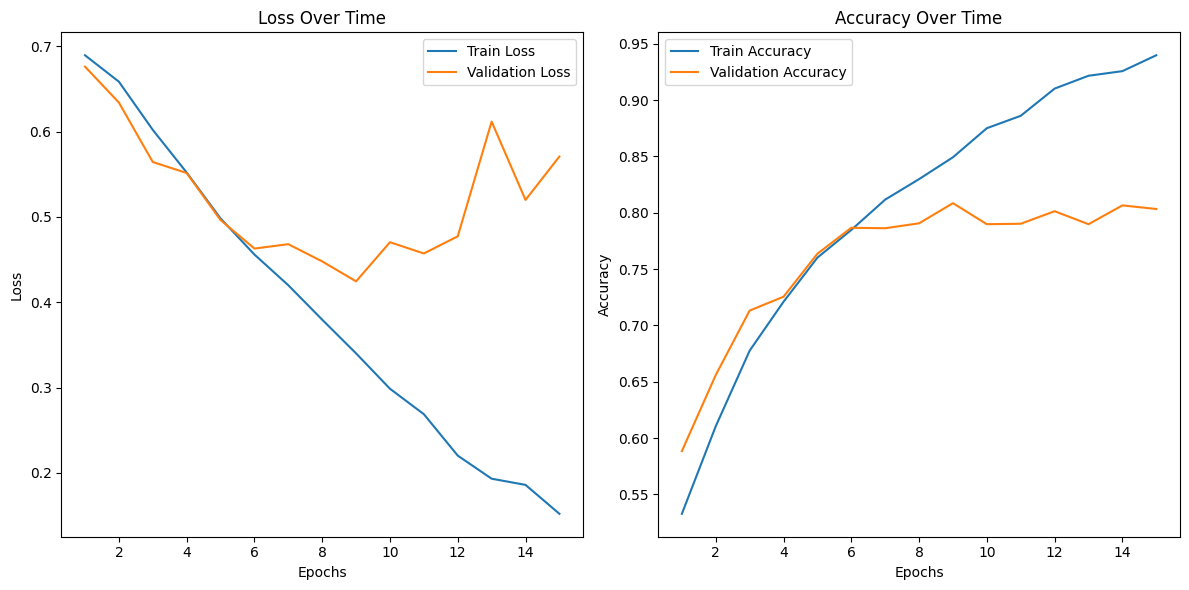

In [31]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), [acc.cpu().item() for acc in train_accuracies], label='Train Accuracy')
plt.plot(range(1, num_epochs+1), [acc.cpu().item() for acc in val_accuracies], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')
plt.legend()


plt.tight_layout()
plt.show()

In [ ]:
# NOTE: if the accuracy on test data after 15 epochs is less than 80% smth goes wrong


C:\Users\Eva_D\AppData\Local\Temp\ipykernel_14748\3264715676.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model_1.evaluate_generator(test_generator, nb_test_samples // batch_size)


Accuracy on test data: 85.58%


Plot the graphs:

- Loss(Number of epochs)

- Accuracy(Number of epochs)

Let's try to improve the quality of recognition, using the method of transfer lerning.

We will use weights of deep neural networks already trained on large dataset such as  ImageNet, and provide fine tuning of several additional dense layers on new data relevant to the current classification task. The more new images will differ from those on which the network has been trained, the more layers will need to be “retrained” in order to get good classification accuracy. The intuition here is that the model has already learned how to highlight the necessary features on the images in the large dataset, it only needs to be “tweaked” for a specific task.

## Task 2(25 points)

1. Build and fit Transfer Learning model using pre-trained VGG16-model weights.
2. Evaluate accuracy on test data for p.1 and p.2
3. Plot the graphs for Loss(number_of_epochs) and Accuracy(number_of_epochs)
4. Check the performance of your model with the custom image of cat or dog (so the model will tell which class this image belongs to). Develop the function for the inference of the best algorithm.

In [4]:
# First, download the weights of the VGG16 network trained on the ImageNet dataset:

from tensorflow.keras.applications import VGG16

vgg16_model = VGG16(weights='imagenet')
vgg16_conv_base = VGG16(weights='imagenet', include_top=False)
vgg16_model.summary()


58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

We construct our model of "transfer learning" by adding two fully connected layers to VGG16

In [5]:
# add layers to VGG16:

from tensorflow.keras.applications import VGG16
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout

vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

for layer in vgg16_base.layers:
    layer.trainable = False
modelvgg = Sequential([
    vgg16_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

modelvgg.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16878145 (64.39 MB)
Trainable params: 2163

In [6]:
# Implement the code to train the model
# Without using a GPU, learning 1 epoch of such a network will take about an hour. Plan your time =)
# If you have access to a GPU, you can try 10-12 epochs - the quality should increase even more.

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
vgg16_base.trainable = False

model = Sequential([
    vgg16_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

train_dir = '/content/drive/MyDrive/Cats_and_Dogs/train'
validation_dir = '/content/drive/MyDrive/Cats_and_Dogs/val'
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')

epochs = 5
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)



Found 20000 images belonging to 2 classes.
Found 2517 images belonging to 2 classes.
Epoch 1/5
625/625 [==============================] - 11577s 18s/step - loss: 0.3028 - accuracy: 0.8701 - val_loss: 0.2324 - val_accuracy: 0.9054
Epoch 2/5
625/625 [==============================] - 75s 119ms/step - loss: 0.2346 - accuracy: 0.9032 - val_loss: 0.2262 - val_accuracy: 0.9139
Epoch 3/5
625/625 [==============================] - 75s 119ms/step - loss: 0.2120 - accuracy: 0.9099 - val_loss: 0.2174 - val_accuracy: 0.9050
Epoch 4/5
625/625 [==============================] - 74s 119ms/step - loss: 0.1968 - accuracy: 0.9179 - val_loss: 0.2077 - val_accuracy: 0.9187
Epoch 5/5
625/625 [==============================] - 74s 118ms/step - loss: 0.1842 - accuracy: 0.9247 - val_loss: 0.2266 - val_accuracy: 0.9018


In [7]:
test_dir = '/content/drive/MyDrive/Cats_and_Dogs/test'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Found 2500 images belonging to 2 classes.
78/78 [==============================] - 604s 8s/step - loss: 0.2447 - accuracy: 0.8982
Test Loss: 0.2446623593568802
Test Accuracy: 0.8982371687889099


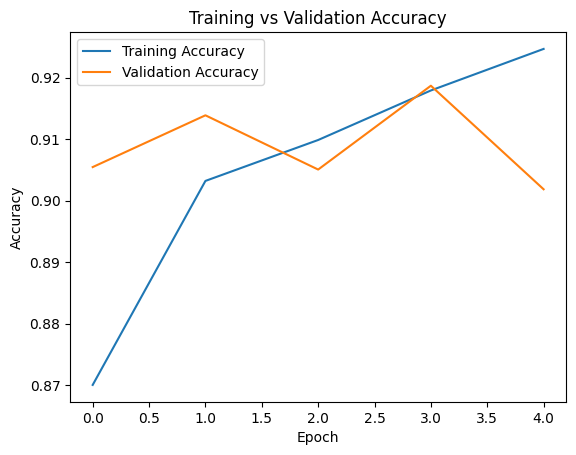

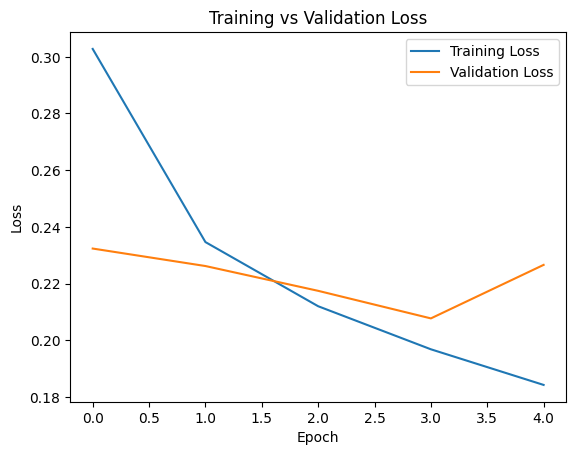

In [8]:
#training vs validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save and Showcase how good is your model

1/1 [==============================] - 1s 588ms/step


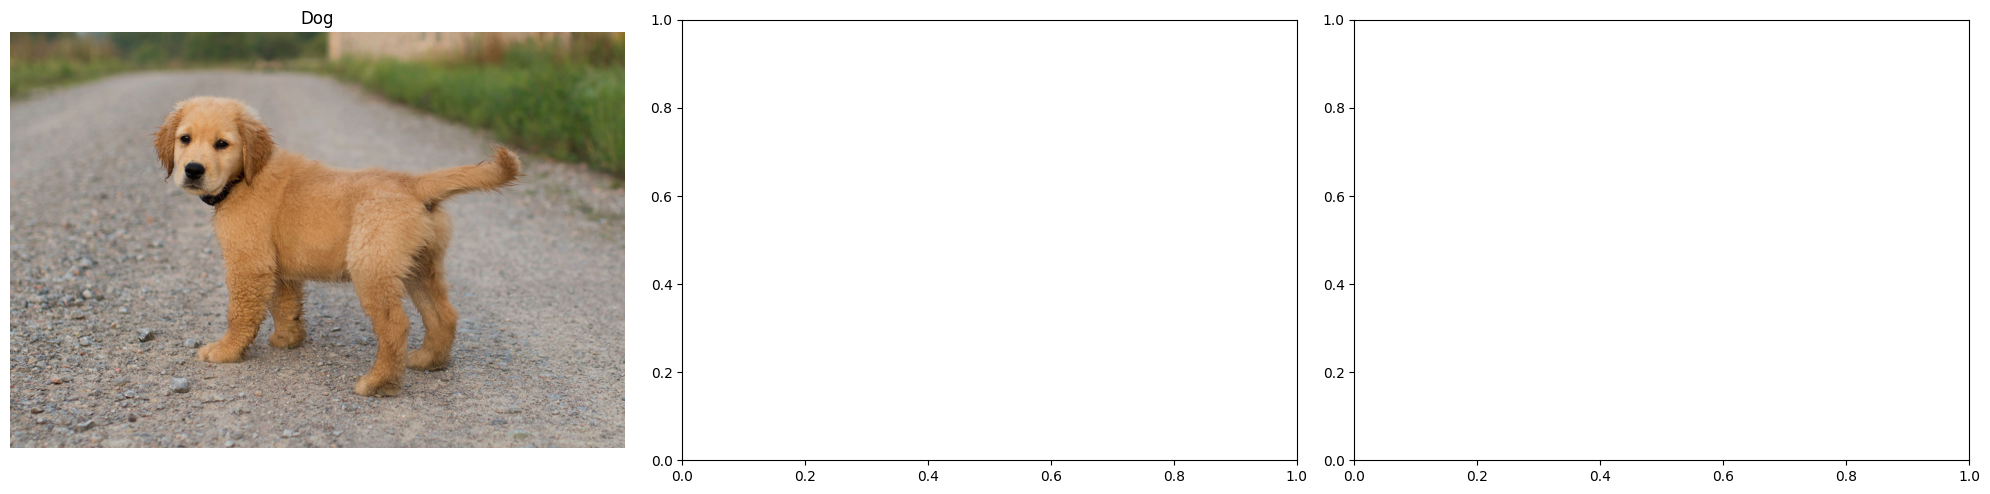

In [5]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

image_paths = ['/content/drive/MyDrive/Cats_and_Dogs/log/puppy-dog.jpg']

def preprocess_image(img_path, target_size=(150, 150)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

predictions = []
for img_path in image_paths:
    img_preprocessed = preprocess_image(img_path)
    pred = model.predict(img_preprocessed)
    predictions.append(pred[0][0])

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for ax, img_path, pred in zip(axes, image_paths, predictions):
    img = load_img(img_path)
    ax.imshow(img)
    ax.set_title('Dog' if pred > 0.5 else 'Cat')
    ax.axis('off')
plt.tight_layout()
plt.show()


In this task, we will create and train a ResNet-based model from scratch to improve classification accuracy.

## Task 3(25 points)
Build and Train ResNet-based Model:

Design a ResNet-based neural network architecture, customizing the number of layers, channels, and other hyperparameters based on classification task.

Plot Loss and Accuracy

Evaluate accuracy on validation and test datasets separately.

In [ ]:
import torch
import torch.nn as nn

# Define the basic building blocks of a ResNet: Residual Block and Residual Layer
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection to match dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


# Create a ResNet model
resnet = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=1)

In [ ]:
# Train your ResNet Model

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)


def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0

    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = torch.sigmoid(outputs) > 0.5
        correct_predictions += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_predictions.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc

def validate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            correct_predictions += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_predictions.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

num_epochs = 14
training_losses = []
validation_losses = []
training_accuracy = []
validation_accuracy = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(resnet, train_dataloader, criterion, optimizer, device)
    val_loss, val_acc = validate_model(resnet, val_dataloader, criterion, device)

    training_losses.append(train_loss)
    validation_losses.append(val_loss)
    training_accuracy.append(train_acc)
    validation_accuracy.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

100%|██████████| 79/79 [00:05<00:00, 15.01it/s]


Epoch 1/14 - Train loss: 0.3124, Accuracy: 0.8626, Val Loss: 0.3296, Val Accuracy: 0.8586


100%|██████████| 79/79 [00:05<00:00, 15.39it/s]


Epoch 2/14 - Train loss: 0.2753, Accuracy: 0.8813, Val Loss: 0.3061, Val Accuracy: 0.8590


100%|██████████| 79/79 [00:05<00:00, 15.53it/s]


Epoch 3/14 - Train loss: 0.2370, Accuracy: 0.9012, Val Loss: 0.2979, Val Accuracy: 0.8709


100%|██████████| 79/79 [00:05<00:00, 15.06it/s]


Epoch 4/14 - Train loss: 0.2060, Accuracy: 0.9137, Val Loss: 0.2658, Val Accuracy: 0.8892


100%|██████████| 79/79 [00:05<00:00, 14.98it/s]


Epoch 5/14 - Train loss: 0.1783, Accuracy: 0.9281, Val Loss: 0.2474, Val Accuracy: 0.9035


100%|██████████| 79/79 [00:05<00:00, 14.82it/s]


Epoch 6/14 - Train loss: 0.1556, Accuracy: 0.9373, Val Loss: 0.2523, Val Accuracy: 0.8995


100%|██████████| 79/79 [00:04<00:00, 16.72it/s]


Epoch 7/14 - Train loss: 0.1313, Accuracy: 0.9469, Val Loss: 0.2892, Val Accuracy: 0.8899


100%|██████████| 79/79 [00:05<00:00, 14.96it/s]


Epoch 8/14 - Train loss: 0.1086, Accuracy: 0.9579, Val Loss: 0.2377, Val Accuracy: 0.9062


100%|██████████| 79/79 [00:05<00:00, 14.71it/s]


Epoch 9/14 - Train loss: 0.0871, Accuracy: 0.9665, Val Loss: 0.2538, Val Accuracy: 0.9138


100%|██████████| 79/79 [00:05<00:00, 14.80it/s]


Epoch 10/14 - Train loss: 0.0818, Accuracy: 0.9673, Val Loss: 0.2974, Val Accuracy: 0.9058


100%|██████████| 79/79 [00:04<00:00, 15.95it/s]


Epoch 11/14 - Train loss: 0.0585, Accuracy: 0.9778, Val Loss: 0.3797, Val Accuracy: 0.8828


100%|██████████| 79/79 [00:05<00:00, 15.30it/s]


Epoch 12/14 - Train loss: 0.0463, Accuracy: 0.9826, Val Loss: 0.3251, Val Accuracy: 0.9082


100%|██████████| 79/79 [00:05<00:00, 15.40it/s]


Epoch 13/14 - Train loss: 0.0391, Accuracy: 0.9867, Val Loss: 0.3257, Val Accuracy: 0.9126


100%|██████████| 79/79 [00:05<00:00, 15.35it/s]

Epoch 14/14 - Train loss: 0.0363, Accuracy: 0.9868, Val Loss: 0.5151, Val Accuracy: 0.8403


In [ ]:
# Test the accuracy
test_loss, test_accuracy = validate_model(resnet, test_dataloader, criterion, device)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

100%|██████████| 79/79 [00:04<00:00, 16.56it/s]

Test Loss: 0.4820, Test Accuracy: 0.8316


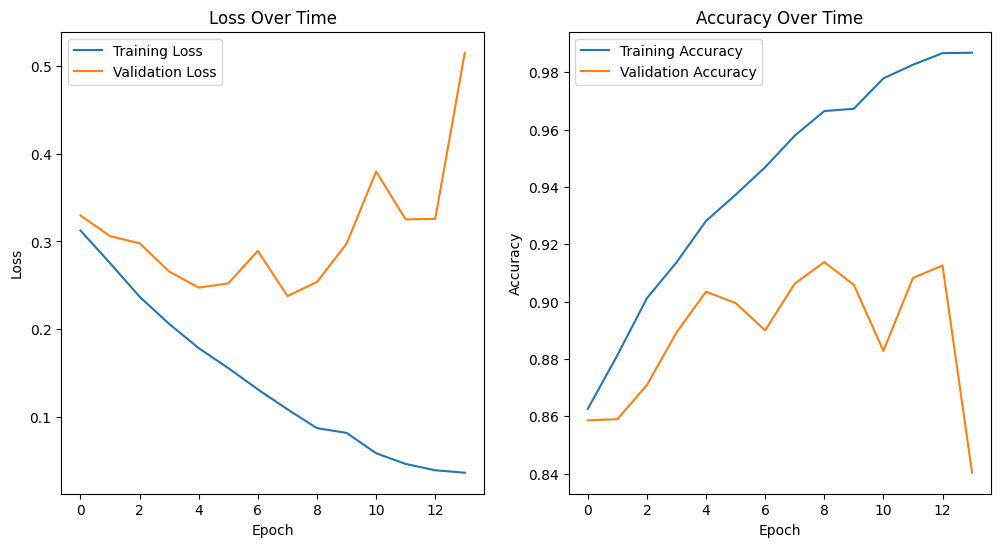

In [ ]:
# Plot loss and accuracy

import matplotlib.pyplot as plt

training_losses_np = [x.cpu().numpy() if torch.is_tensor(x) else x for x in training_losses]
validation_losses_np = [x.cpu().numpy() if torch.is_tensor(x) else x for x in validation_losses]
training_accuracy_np = [x.cpu().numpy() if torch.is_tensor(x) else x for x in training_accuracy]
validation_accuracy_np = [x.cpu().numpy() if torch.is_tensor(x) else x for x in validation_accuracy]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_losses_np, label='Training Loss')
plt.plot(validation_losses_np, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_accuracy_np, label='Training Accuracy')
plt.plot(validation_accuracy_np, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')
plt.legend()

plt.show()

In this task, we will create and train a UNet-based model from scratch to improve classification accuracy.

## Task 4(25 points)
Build and Train UNet-based Model for binary classification task:

Design a UNet-based neural network architecture, customizing the encoder,bottleneck, and the decoder structure.

Plot Loss and Accuracy

Evaluate accuracy on test datasets.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BottleneckBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, skip_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels + skip_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x, bridge):
        up = self.upconv(x)
        out = torch.cat([up, bridge], dim=1)
        out = self.conv(out)
        return out

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        # Encoder
        self.enc1 = EncoderBlock(in_channels, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)

        # Bottleneck
        self.bottleneck = BottleneckBlock(512, 1024)

        # Decoder
        self.dec1 = DecoderBlock(1024, 512, 512)
        self.dec2 = DecoderBlock(512, 256, 256)
        self.dec3 = DecoderBlock(256, 128, 128)
        self.dec4 = DecoderBlock(128, 64, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))

        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        dec1 = self.dec1(bottleneck, enc4)
        dec2 = self.dec2(dec1, enc3)
        dec3 = self.dec3(dec2, enc2)
        dec4 = self.dec4(dec3, enc1)

        return torch.sigmoid(self.final(dec4))

# Create a U-Net model for binary classification
unet = UNet(in_channels=3, out_channels=1)

# Define Binary Cross-Entropy loss and an optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=0.001)


In [7]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

resize = transforms.Resize(size=(256, 256))
trainTransforms = transforms.Compose([resize, transforms.ToTensor()])
testTransforms = transforms.Compose([resize, transforms.ToTensor()])

train_path = '/content/drive/MyDrive/Cats_and_Dogs/train/'
test_path = '/content/drive/MyDrive/Cats_and_Dogs/test/'
val_path = '/content/drive/MyDrive/Cats_and_Dogs/val/'

train_data_resized = ImageFolder(train_path, transform=trainTransforms)
val_data_resized = ImageFolder(val_path, transform=testTransforms)
test_data_resized = ImageFolder(test_path, transform=testTransforms)

BATCH_SIZE = 32
train_dataloader_resized = DataLoader(train_data_resized, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader_resized = DataLoader(val_data_resized, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_dataloader_resized = DataLoader(test_data_resized, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


In [10]:
#Define the model training process

import torch
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_model(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in tqdm(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = F.adaptive_avg_pool2d(outputs, (1, 1)).view(outputs.size(0), -1)
            preds = outputs > 0.5
            loss = criterion(outputs, labels.float().unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.unsqueeze(1))

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc.item())
        print(f'Epoch {epoch}/{num_epochs - 1} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                outputs = F.adaptive_avg_pool2d(outputs, (1, 1)).view(outputs.size(0), -1)
                preds = outputs > 0.5
                loss = criterion(outputs, labels.float().unsqueeze(1))
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.unsqueeze(1))

        val_loss = val_loss / len(val_dataloader.dataset)
        val_acc = val_corrects.double() / len(val_dataloader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc.item())
        print(f'Epoch {epoch}/{num_epochs - 1} Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    return train_losses, val_losses, train_accs, val_accs

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
unet.to(device)
criterion.to(device)

train_losses, val_losses, train_accs, val_accs = train_model(unet, criterion, optimizer, train_dataloader_resized, val_dataloader_resized, num_epochs=10)



100%|██████████| 625/625 [04:47<00:00,  2.17it/s]


Epoch 0/9 Train Loss: 0.5918 Acc: 0.6848


100%|██████████| 79/79 [00:12<00:00,  6.51it/s]


Epoch 0/9 Val Loss: 0.5754 Acc: 0.6969


100%|██████████| 625/625 [04:47<00:00,  2.17it/s]


Epoch 1/9 Train Loss: 0.5505 Acc: 0.7223


100%|██████████| 79/79 [00:12<00:00,  6.51it/s]


Epoch 1/9 Val Loss: 0.5120 Acc: 0.7712


100%|██████████| 625/625 [04:47<00:00,  2.17it/s]


Epoch 2/9 Train Loss: 0.5035 Acc: 0.7612


100%|██████████| 79/79 [00:12<00:00,  6.52it/s]


Epoch 2/9 Val Loss: 0.4776 Acc: 0.7684


100%|██████████| 625/625 [04:47<00:00,  2.17it/s]


Epoch 3/9 Train Loss: 0.4651 Acc: 0.7901


100%|██████████| 79/79 [00:12<00:00,  6.48it/s]


Epoch 3/9 Val Loss: 0.4485 Acc: 0.7982


100%|██████████| 625/625 [04:47<00:00,  2.17it/s]


Epoch 4/9 Train Loss: 0.4277 Acc: 0.8124


100%|██████████| 79/79 [00:12<00:00,  6.53it/s]


Epoch 4/9 Val Loss: 0.4444 Acc: 0.7998


100%|██████████| 625/625 [04:48<00:00,  2.17it/s]


Epoch 5/9 Train Loss: 0.4023 Acc: 0.8288


100%|██████████| 79/79 [00:12<00:00,  6.51it/s]


Epoch 5/9 Val Loss: 0.4202 Acc: 0.8061


100%|██████████| 625/625 [04:48<00:00,  2.17it/s]


Epoch 6/9 Train Loss: 0.3617 Acc: 0.8528


100%|██████████| 79/79 [00:12<00:00,  6.49it/s]


Epoch 6/9 Val Loss: 0.4135 Acc: 0.8061


100%|██████████| 625/625 [04:47<00:00,  2.17it/s]


Epoch 7/9 Train Loss: 0.3304 Acc: 0.8708


100%|██████████| 79/79 [00:12<00:00,  6.49it/s]


Epoch 7/9 Val Loss: 0.4445 Acc: 0.7847


100%|██████████| 625/625 [04:47<00:00,  2.17it/s]


Epoch 8/9 Train Loss: 0.3060 Acc: 0.8861


100%|██████████| 79/79 [00:12<00:00,  6.49it/s]


Epoch 8/9 Val Loss: 0.4870 Acc: 0.7731


100%|██████████| 625/625 [04:47<00:00,  2.17it/s]


Epoch 9/9 Train Loss: 0.2843 Acc: 0.8994


100%|██████████| 79/79 [00:12<00:00,  6.51it/s]

Epoch 9/9 Val Loss: 0.2940 Acc: 0.8915


In [11]:
#Evaluate accuracy on test datasets.

def evaluate_model(model, dataloader, device):
    model.eval()
    corrects = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            outputs = F.adaptive_avg_pool2d(outputs, (1, 1)).view(outputs.size(0), -1)
            preds = outputs > 0.5

            total += labels.size(0)
            corrects += torch.sum(preds == labels.unsqueeze(1)).item()

    accuracy = corrects / total
    print(f'Test Accuracy: {accuracy:.4f}')
evaluate_model(unet, test_dataloader_resized, device)




100%|██████████| 79/79 [03:39<00:00,  2.78s/it]

Test Accuracy: 0.8880


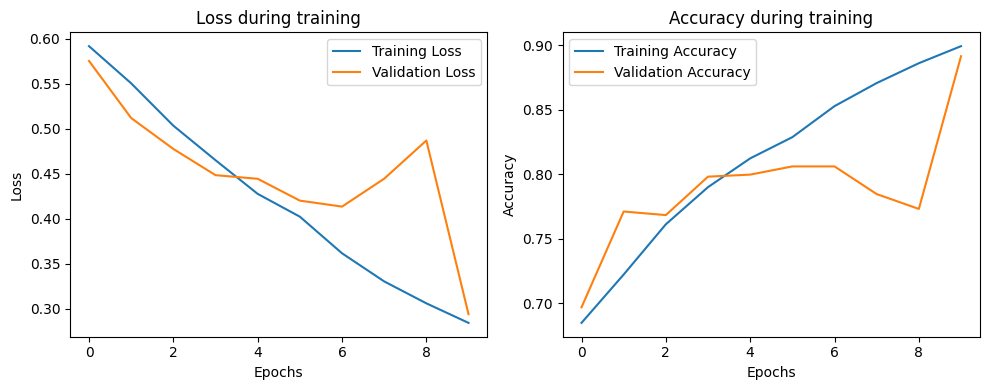

In [12]:
#Plot Loss and Accuracy

# Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()





# **References**
https://discuss.pytorch.org/t/resnet-for-binary-classification/32464

https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/

https://www.analyticsvidhya.com/blog/2022/10/image-segmentation-with-u-net/


https://towardsdatascience.com/creating-vgg-from-scratch-using-tensorflow-a998a5640155
